# Makine Öğrenimi ile Konut Fiyat Tahmini: 
## Feature (Öznitelik) Engineering ve Hibrid Model 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_excel("C:\\konut\\istanbul_konut2.xlsx")

In [3]:
# Eksik değerlerin toplamını ve oranını göster
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Eksik değer tablosu oluştur
missing_data = pd.DataFrame({'Eksik Değerler': missing_values, 'Eksik Oranı (%)': missing_percent})
print(missing_data)


               Eksik Değerler  Eksik Oranı (%)
Fiyat                       0         0.000000
İlce                        0         0.000000
Mahalle                     0         0.000000
Metre Kare                  0         0.000000
Oda Sayısı                  2         0.006988
Yaş                        24         0.083852
Bulunduğu Kat             936         3.270212


In [4]:
# 'Yaş' sütunundaki eksik değerleri medyan ile doldur
df['Yaş'] = df['Yaş'].fillna(df['Yaş'].median())
# 'Bulunduğu Kat' sütunundaki eksik değerleri mod ile doldur
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].fillna(df['Bulunduğu Kat'].mode()[0])
# Oda Sayısı sütunundaki eksik değerleri mod (en sık görülen değer) ile doldur
most_frequent_value = df['Oda Sayısı'].mode()[0]
df['Oda Sayısı'] = df['Oda Sayısı'].fillna(most_frequent_value)
print(df.isnull().sum())

Fiyat            0
İlce             0
Mahalle          0
Metre Kare       0
Oda Sayısı       0
Yaş              0
Bulunduğu Kat    0
dtype: int64


### Target Encoding (Mean Encoding)
Her bir ilçe/mahalle, o ilçe/mahalledeki ortalama konut fiyatı ile değiştirilir

In [7]:
# Target Encoding uygulama
def target_encode(df, target_col):
    # İlce için ortalama fiyatları hesapla
    ilce_means = df.groupby('İlce')[target_col].mean()
    df['Ilce_encoded'] = df['İlce'].map(ilce_means)

    # Mahalle için ortalama fiyatları hesapla
    mahalle_means = df.groupby('Mahalle')[target_col].mean()
    df['Mahalle_encoded'] = df['Mahalle'].map(mahalle_means)

    return df

# Target Encoding'i uygula
df_encoded = target_encode(df.copy(), 'Fiyat')

# Özellikler (X) ve hedef değişkeni (y) belirleyelim
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modelini oluştur ve eğit
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = model.predict(X_test)

# R² skorunu hesapla
r2 = r2_score(y_test, y_pred)

# Sonucu yazdır
print("Target Encoding uygulanmış veri seti ile R² değeri (Random Forest):")
print("R² Score:", r2)


Target Encoding uygulanmış veri seti ile R² değeri (Random Forest):
R² Score: 0.8296936501480221


# Outlier Değerleri Temizleme

## Hibrid Yöntem - (IQR  + Manuel Veri Temizleme)

In [8]:
df_new=df_encoded.copy()

In [9]:
df_new=df_encoded[df_encoded["Oda Sayısı"]<8]
df_new=df_encoded[df_encoded["Yaş"]<57]
df_new = df_encoded[(df_encoded["Metre Kare"] < 270) & (df_encoded["Metre Kare"] > 40)]

In [10]:
X_clean = df_new[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y_clean = df_new['Fiyat']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'Manuel Temizleme Sonrası R^2 Skoru: {r2:.4f}')
print(f'Manuel Temizleme Sonrası Veri sayısı: {len(X_clean)}')

Manuel Temizleme Sonrası R^2 Skoru: 0.8334
Manuel Temizleme Sonrası Veri sayısı: 27961


In [11]:
df_clean = pd.concat([X_clean, y_clean], axis=1)
# İlçe bazında Fiyat, Metre Kare, Oda Sayısı ve Yaş değişkenleri için ortalama ve standart sapma hesaplama
stats = df_clean.groupby('Ilce_encoded').agg(
    Fiyat_mean=('Fiyat', 'mean'), Fiyat_std=('Fiyat', 'std'),
    MetreKare_mean=('Metre Kare', 'mean'), MetreKare_std=('Metre Kare', 'std'),
    OdaSayisi_mean=('Oda Sayısı', 'mean'), OdaSayisi_std=('Oda Sayısı', 'std'),
    Yas_mean=('Yaş', 'mean'), Yas_std=('Yaş', 'std')
).reset_index()

# Aykırı değer eşiğini hesaplama ve kontrol etme
def is_outlier(row, stats):
    ilce_stats = stats[stats['Ilce_encoded'] == row['Ilce_encoded']].iloc[0]
    
    # Eşik değerler
    fiyat_threshold = ilce_stats['Fiyat_mean'] + 2 * ilce_stats['Fiyat_std'] + 1
    metrekare_threshold = ilce_stats['MetreKare_mean'] + 2 * ilce_stats['MetreKare_std'] + 1
    odasayisi_threshold = ilce_stats['OdaSayisi_mean'] + 2 * ilce_stats['OdaSayisi_std'] + 1
    yas_threshold = ilce_stats['Yas_mean'] + 2 * ilce_stats['Yas_std'] + 1

    # Aykırı değer kontrolü
    if (row['Fiyat'] > fiyat_threshold or 
        row['Metre Kare'] > metrekare_threshold or 
        row['Oda Sayısı'] > odasayisi_threshold or 
        row['Yaş'] > yas_threshold):
        return True
    return False

# Aykırı değerleri filtreleme
filtered_data = df_clean[~df_clean.apply(lambda row: is_outlier(row, stats), axis=1)]

# Sonuç
print(f"Orijinal veri boyutu: {len(df_clean)}")
print(f"İlçe Bazlı Temizlenme sonucu  veri boyutu: {len(filtered_data)}")


Orijinal veri boyutu: 27961
İlçe Bazlı Temizlenme sonucu  veri boyutu: 24973


In [12]:
filtered_data

,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat,Ilce_encoded,Mahalle_encoded,Fiyat
0,55,2.0,24.0,0.0,1.047431e+07,1.064654e+07,5000000
1,65,2.0,31.0,0.0,1.047431e+07,1.104514e+07,7500000
2,60,2.0,34.0,0.0,1.047431e+07,1.104514e+07,4750000
3,75,2.0,35.0,0.0,1.047431e+07,9.944185e+06,7000000
4,51,2.0,38.0,0.0,1.047431e+07,1.104514e+07,4200000
...,...,...,...,...,...,...,...
28604,150,5.0,30.0,0.0,4.050061e+06,1.965306e+06,3000000
28607,125,5.0,31.0,0.0,4.050061e+06,4.250833e+06,2650000
28608,150,5.0,31.0,1.0,4.050061e+06,3.729308e+06,4449000
28614,150,6.0,25.0,1.0,4.050061e+06,3.708659e+06,4200000


In [13]:
# df_clean = pd.concat([X_clean, y_clean], axis=1)

In [14]:
# Özellikler ve hedef değişkeni belirleme
X = filtered_data[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = filtered_data['Fiyat']

# IQR yöntemiyle aykırı değerleri temizleme
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'IQR sonrası Veri boyutu: {len(X_clean)}')

R^2 Skoru: 0.8932
IQR sonrası Veri boyutu: 24129


# Feature Engineering (Öznitelik Mühendisliği)

In [18]:
# Veriyi kopyalayarak Feature Engineering işlemi yapalım
df = X_clean.copy()

# Yeni değişkenler
df.loc[:, 'Metre_Kare_per_Oda'] = df['Metre Kare'] / df['Oda Sayısı']
df.loc[:, 'Kat_Oranı'] = df['Bulunduğu Kat'] / df['Bulunduğu Kat'].max()
df.loc[:, 'Log_Metre_Kare'] = np.log1p(df['Metre Kare'])
df.loc[:, 'Metre_Kare_X_Kat'] = df['Metre Kare'] * df['Bulunduğu Kat']

# Mahalle ve İlçe Bazlı Yeni Özellikler
df.loc[:, 'Mahalle_MetreKare_Ortalamasi'] = df.groupby('Mahalle_encoded')['Metre Kare'].transform('mean')
df.loc[:, 'Ilce_MetreKare_Ortalamasi'] = df.groupby('Ilce_encoded')['Metre Kare'].transform('mean')
X_train, X_test, y_train, y_test = train_test_split(df, y_clean, test_size=0.2, random_state=42)


In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # 0'a bölünmeyi engellemek için küçük bir değer
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    results = {}
    
    # 1. Optimized Random Forest
    rf = RandomForestRegressor(
        n_estimators=200, 
        max_depth=30, 
        min_samples_split=2, 
        min_samples_leaf=5, 
        max_features='sqrt', 
        bootstrap=False, 
        random_state=42
    )
    rf.fit(X_train, y_train)
    results['Random Forest'] = rf
    
    # 2. Optimized Extra Trees
    et = ExtraTreesRegressor(
        n_estimators=200,
        max_depth=20,
        max_features=None,
        min_samples_leaf=3,
        min_samples_split=7,
        random_state=42
    )
    et.fit(X_train, y_train)
    results['Extra Trees'] = et
    
    # 3. Optimized Gradient Boosting with Deep Trees
    gb_deep = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_leaf=1,
        min_samples_split=5,
        subsample=0.8,
        random_state=42
    )
    gb_deep.fit(X_train, y_train)
    results['Deep Gradient Boosting'] = gb_deep
    
    # 4. XGBoost (Default settings)
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    xgb.fit(X_train, y_train)
    results['XGBoost'] = xgb
    
    # 5. LightGBM (Default settings)
    lgbm = LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    lgbm.fit(X_train, y_train)
    results['LightGBM'] = lgbm
    
    # Modelleri değerlendir
    print("Öznitelik Artırımı Sonrası Model Performansları:")
    print("-" * 120)
    print(f"{'Model':30} {'MSE':>10} {'R2 Test':>15} {'MAPE Test':>13} {'R2 Train':>15} {'MAPE Train':>13}")
    print("-" * 120)
    
    for name, model in results.items():
        # Test seti üzerindeki tahminler
        y_pred_test = model.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

        # Eğitim seti üzerindeki tahminler
        y_pred_train = model.predict(X_train)
        r2_train = r2_score(y_train, y_pred_train)
        mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
        
        print(f"{name:30} {mse_test:10.4f} {r2_test:10.4f} {mape_test:10.2f}% {r2_train:10.4f} {mape_train:10.2f}%")
    
    print("-" * 120)
    return results

# Kullanım örneği:
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 19303, number of used features: 12
[LightGBM] [Info] Start training from score 5578966.878724
Öznitelik Artırımı Sonrası Model Performansları:
------------------------------------------------------------------------------------------------------------------------
Model                                 MSE         R2 Test     MAPE Test        R2 Train    MAPE Train
------------------------------------------------------------------------------------------------------------------------
Random Forest                  1893341526120.7087     0.8960      17.49%     0.9355      12.88%
Extra Trees                    1850067545175.5334     0.8984      16.99%     0.9495

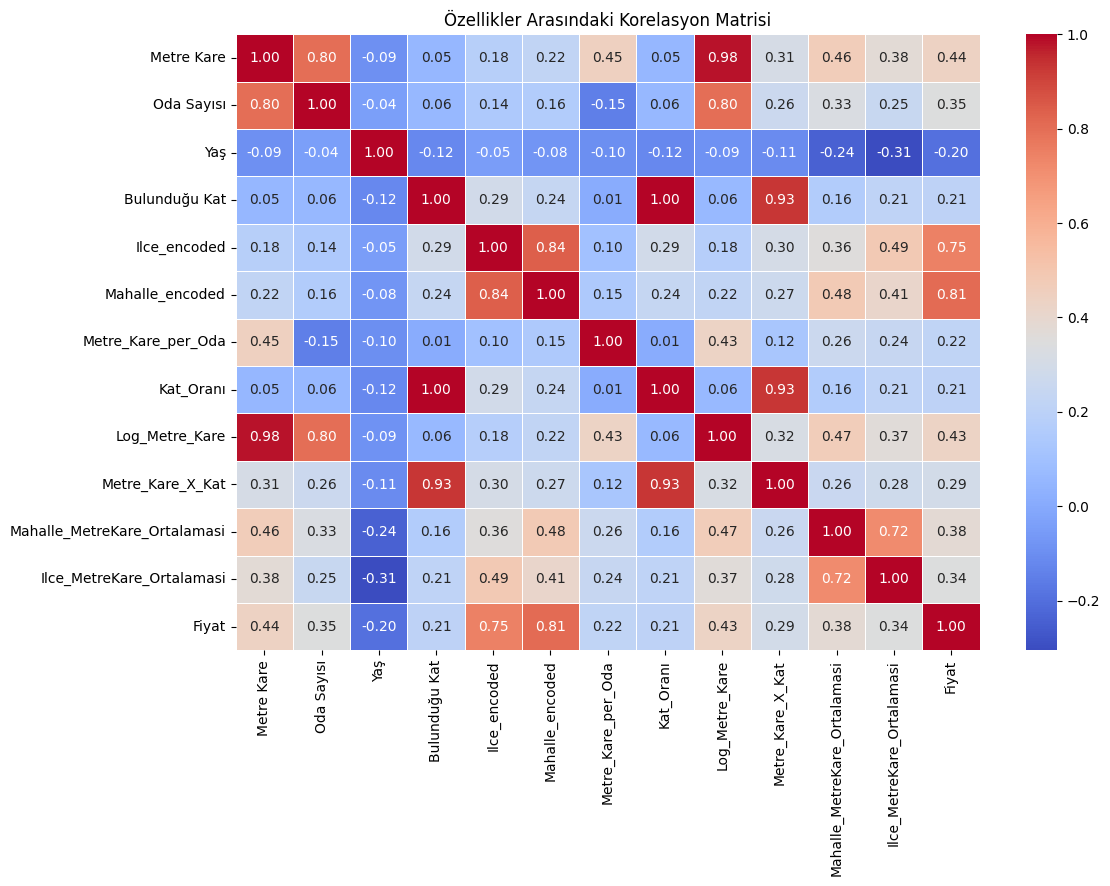

In [20]:
df = pd.concat([df, y_clean], axis=1)
# Korelasyon matrisini hesapla
corr_matrix = df.corr()

# Isı haritasını oluştur
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Başlık ekle
plt.title("Özellikler Arasındaki Korelasyon Matrisi")
plt.show()


Mean Absolute Error (MAE): 855324.4584952139
Mean Squared Error (MSE): 1909681632326.4226
Root Mean Squared Error (RMSE): 1381912.30992651
R² Score: 0.8950780276128381


C:\Users\yunus\AppData\Local\Temp\ipykernel_17476\1371211745.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


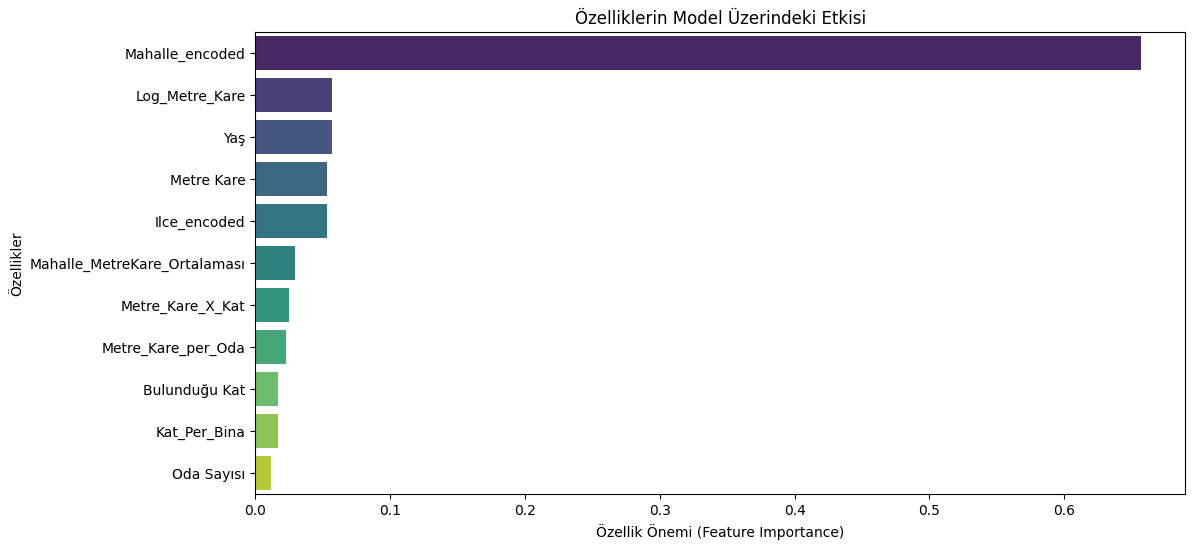

In [21]:
from sklearn.preprocessing import StandardScaler

# Veriyi kopyalayarak Feature Engineering işlemi yapalım
df = X_clean.copy()

# Yeni değişkenler
df.loc[:, 'Metre_Kare_per_Oda'] = df['Metre Kare'] / df['Oda Sayısı']
df.loc[:, 'Kat_Per_Bina'] = df['Bulunduğu Kat'] / df['Bulunduğu Kat'].max()
df.loc[:, 'Log_Metre_Kare'] = np.log1p(df['Metre Kare'])
df.loc[:, 'Metre_Kare_X_Kat'] = df['Metre Kare'] * df['Bulunduğu Kat']

# Mahalle ile ilgili yeni değişkenler
df.loc[:, 'Mahalle_MetreKare_Ortalaması'] = df.groupby('Mahalle_encoded')['Metre Kare'].transform('mean')

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(df, y_clean, test_size=0.2, random_state=42)


# Modeli tanımla ve eğit
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = model.predict(X_test)

# Performans metriklerini hesapla
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Performans sonuçları
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Özellik önem sıralaması
feature_importances = model.feature_importances_
feature_names = X_train.columns

# DataFrame oluştur
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel("Özellik Önemi (Feature Importance)")
plt.ylabel("Özellikler")
plt.title("Özelliklerin Model Üzerindeki Etkisi")
plt.show()


Mean Absolute Error (MAE): 864001.9648974524
Mean Squared Error (MSE): 1993082420279.3992
Root Mean Squared Error (RMSE): 1411765.7101231066
R² Score: 0.8904958108587242


C:\Users\yunus\AppData\Local\Temp\ipykernel_17476\3215970440.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


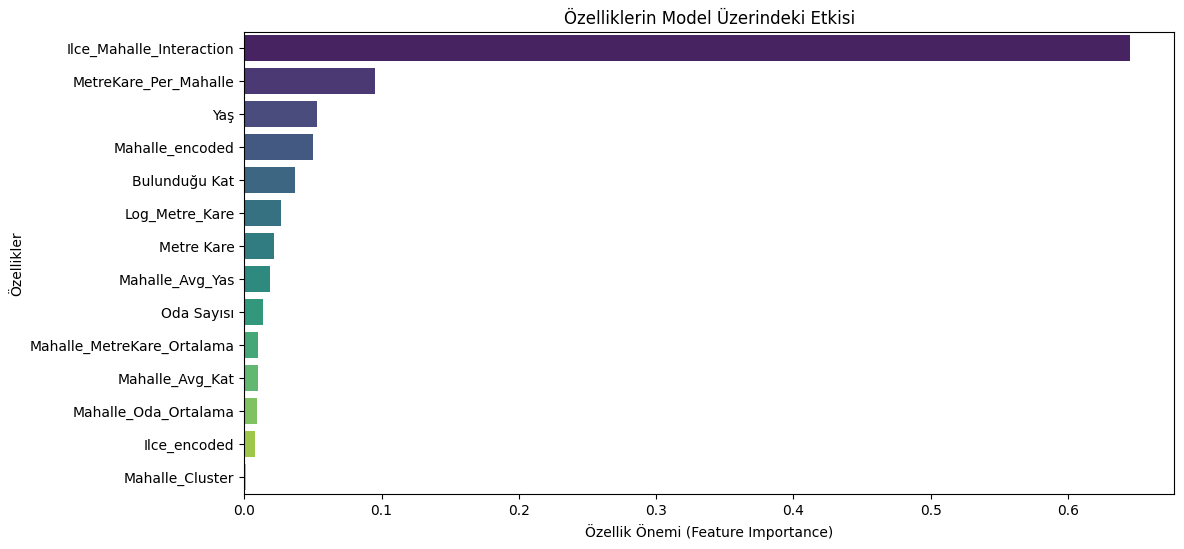

In [22]:
from sklearn.preprocessing import StandardScaler

# Veriyi kopyalayarak Feature Engineering işlemi yapalım
df = X_clean.copy()

from sklearn.cluster import KMeans

# Mahalle bazında ortalama değerleri al
mahalle_features = df.groupby('Mahalle_encoded').mean()

# 5 küme belirleyerek K-Means modeli eğit
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df.loc[:, 'Mahalle_Cluster'] = df['Mahalle_encoded'].map(
    dict(zip(mahalle_features.index, kmeans.fit_predict(mahalle_features)))
)
df.loc[:, 'Log_Metre_Kare'] = np.log1p(df['Metre Kare'])
df.loc[:, 'Ilce_Mahalle_Interaction'] = df['Ilce_encoded'] * df['Mahalle_encoded']

df.loc[:, 'MetreKare_Per_Mahalle'] = df['Metre Kare'] / df.groupby('Mahalle_encoded')['Metre Kare'].transform('mean')

df.loc[:, 'Mahalle_Avg_Yas'] = df.groupby('Mahalle_encoded')['Yaş'].transform('mean')
df.loc[:, 'Mahalle_Avg_Kat'] = df.groupby('Mahalle_encoded')['Bulunduğu Kat'].transform('mean')


df.loc[:, 'Mahalle_Oda_Ortalama'] = df.groupby('Mahalle_encoded')['Oda Sayısı'].transform('mean')
df.loc[:, 'Mahalle_MetreKare_Ortalama'] = df.groupby('Mahalle_encoded')['Metre Kare'].transform('mean')


# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(df, y_clean, test_size=0.2, random_state=42)


# Modeli tanımla ve eğit
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = model.predict(X_test)

# Performans metriklerini hesapla
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Performans sonuçları
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Özellik önem sıralaması
feature_importances = model.feature_importances_
feature_names = X_train.columns

# DataFrame oluştur
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel("Özellik Önemi (Feature Importance)")
plt.ylabel("Özellikler")
plt.title("Özelliklerin Model Üzerindeki Etkisi")
plt.show()


# Hibrid Yöntem

In [23]:
df_clean = pd.concat([X_clean, y_clean], axis=1)

In [24]:
X_clean = df_clean[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y_clean = df_clean['Fiyat']

In [25]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

## 1- Weighted Averaging (Ağırlıklı Ortalama)

In [29]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error

class ThreeModelHybrid:
    def __init__(self):
        # Random Forest
        self.rf = RandomForestRegressor(
            n_estimators=200, 
            max_depth=30, 
            min_samples_split=2, 
            min_samples_leaf=5, 
            max_features='sqrt', 
            bootstrap=False, 
            random_state=42
        )
        
        # Extra Trees
        self.et = ExtraTreesRegressor(
            n_estimators=200,
            max_depth=20,
            max_features=None,
            min_samples_leaf=3,
            min_samples_split=7,
            random_state=42
        )
        
        # Gradient Boosting
        self.gb = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_samples_leaf=1,
            min_samples_split=5,
            subsample=0.8,
            random_state=42
        )
        
        self.models = [self.rf, self.et, self.gb]
        self.weights = None

    def fit(self, X, y):
        print("Model Eğitimi Başlıyor...")
        
        # Her modeli eğit ve R2 skorlarını hesapla
        scores = []
        for model in self.models:
            model.fit(X, y)
            y_pred = model.predict(X)
            score = r2_score(y, y_pred)
            scores.append(score)
        
        # Skorları ağırlıklara dönüştür
        scores = np.array(scores)
        self.weights = scores / scores.sum()
        
        print("\nModel Ağırlıkları:")
        model_names = ['Random Forest', 'Extra Trees', 'Gradient Boosting']
        for name, weight in zip(model_names, self.weights):
            print(f"{name}: {weight:.4f}")
        
        return self

    def predict(self, X):
        # Her modelden tahmin al
        predictions = np.column_stack([
            model.predict(X) for model in self.models
        ])
        
        # Ağırlıklı ortalama hesapla
        final_predictions = np.average(predictions, weights=self.weights, axis=1)
        return final_predictions

    def evaluate(self, X_train, X_test, y_train, y_test):
        # Eğitim ve test tahminleri
        y_pred_train = self.predict(X_train)
        y_pred_test = self.predict(X_test)
        
        # Her model için ayrı performans
        print("\nTek Tek Model Performansları:")
        print("-" * 50)
        model_names = ['Random Forest', 'Extra Trees', 'Gradient Boosting']
        
        for name, model in zip(model_names, self.models):
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            print(f"\n{name}:")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Test R²: {test_r2:.4f}")
        
        # Hibrid model performansı
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test),
            'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_test))
        }
        
        print("\nHibrid Model Performansı:")
        print("-" * 50)
        print(f"Train R² Skoru: {metrics['r2_train']:.4f}")
        print(f"Test R² Skoru: {metrics['r2_test']:.4f}")
        print(f"Train RMSE: {metrics['rmse_train']:.2f}")
        print(f"Test RMSE: {metrics['rmse_test']:.2f}")
        
        return metrics

def train_hybrid_model(X_train, X_test, y_train, y_test):
    # Hibrid modeli oluştur ve eğit
    hybrid_model = ThreeModelHybrid()
    hybrid_model.fit(X_train, y_train)
    
    # Performansı değerlendir
    metrics = hybrid_model.evaluate(X_train, X_test, y_train, y_test)
    
    print(f"\nVeri Seti Boyutları:")
    print(f"Eğitim seti: {len(X_train)} örnek")
    print(f"Test seti: {len(X_test)} örnek")
    
    return hybrid_model, metrics

# Modeli çalıştır
hybrid_model, metrics = train_hybrid_model(X_train, X_test, y_train, y_test)

Model Eğitimi Başlıyor...

Model Ağırlıkları:
Random Forest: 0.3373
Extra Trees: 0.3418
Gradient Boosting: 0.3209

Tek Tek Model Performansları:
--------------------------------------------------

Random Forest:
Train R²: 0.9271
Test R²: 0.8919

Extra Trees:
Train R²: 0.9395
Test R²: 0.8942

Gradient Boosting:
Train R²: 0.8818
Test R²: 0.8789

Hibrid Model Performansı:
--------------------------------------------------
Train R² Skoru: 0.9222
Test R² Skoru: 0.8929
Train RMSE: 1174009.78
Test RMSE: 1396147.66

Veri Seti Boyutları:
Eğitim seti: 19303 örnek
Test seti: 4826 örnek


## 2-Stacking (Üst Üste Bindirme – Meta Model Kullanımı)

In [30]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

class StackingRegressor:
    def __init__(self, n_splits=5):
        # Base modeller
        self.rf = RandomForestRegressor(
            n_estimators=200, 
            max_depth=30, 
            min_samples_split=2, 
            min_samples_leaf=5, 
            max_features='sqrt', 
            bootstrap=False, 
            random_state=42
        )
        
        self.et = ExtraTreesRegressor(
            n_estimators=200,
            max_depth=20,
            max_features=None,
            min_samples_leaf=3,
            min_samples_split=7,
            random_state=42
        )
        
        self.gb = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_samples_leaf=1,
            min_samples_split=5,
            subsample=0.8,
            random_state=42
        )
        
        # Meta-model (GradientBoosting kullanıyoruz çünkü nonlineer ilişkileri iyi yakalıyor)
        self.meta_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.03,
            max_depth=3,
            random_state=42
        )
        
        self.base_models = [self.rf, self.et, self.gb]
        self.n_splits = n_splits
        self.fitted_base_models = None

    def _get_oof_predictions(self, X, y):
        """Out-of-fold tahminleri oluşturur"""
        oof_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        # Her model için k-fold cross validation ile tahminler
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        
        # Her model için OOF tahminleri hesapla
        for i, model in enumerate(self.base_models):
            print(f"\nModel {i+1}/{len(self.base_models)} için OOF tahminleri oluşturuluyor...")
            for train_idx, val_idx in kf.split(X):
                # Fold'u eğit
                X_train_fold = X[train_idx]
                y_train_fold = y[train_idx]
                X_val_fold = X[val_idx]
                
                # Modeli eğit ve tahmin yap
                model_clone = model.__class__(**model.get_params())
                model_clone.fit(X_train_fold, y_train_fold)
                fold_preds = model_clone.predict(X_val_fold)
                
                # OOF tahminleri kaydet
                oof_predictions[val_idx, i] = fold_preds
        
        return oof_predictions

    def fit(self, X, y):
        print("Stacking Model Eğitimi Başlıyor...")
        X = np.array(X)
        y = np.array(y)
        
        # Out-of-fold tahminleri al
        meta_features = self._get_oof_predictions(X, y)
        
        # Base modelleri tam veri setiyle eğit
        print("\nBase modeller tam veri setiyle eğitiliyor...")
        self.fitted_base_models = []
        for i, model in enumerate(self.base_models):
            print(f"Base Model {i+1}/{len(self.base_models)} eğitiliyor...")
            model.fit(X, y)
            self.fitted_base_models.append(model)
        
        # Meta-modeli eğit
        print("\nMeta-model eğitiliyor...")
        self.meta_model.fit(meta_features, y)
        
        return self

    def predict(self, X):
        X = np.array(X)
        # Base modellerden tahminleri al
        meta_features = np.column_stack([
            model.predict(X) for model in self.fitted_base_models
        ])
        
        # Meta-model ile final tahminleri yap
        return self.meta_model.predict(meta_features)

    def evaluate(self, X_train, X_test, y_train, y_test):
        # Base modellerin performansı
        print("\nBase Model Performansları:")
        print("-" * 50)
        model_names = ['Random Forest', 'Extra Trees', 'Gradient Boosting']
        
        for name, model in zip(model_names, self.fitted_base_models):
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            
            print(f"\n{name}:")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Test R²: {test_r2:.4f}")
            print(f"Train RMSE: {train_rmse:.2f}")
            print(f"Test RMSE: {test_rmse:.2f}")
        
        # Stacking modelin performansı
        y_pred_train = self.predict(X_train)
        y_pred_test = self.predict(X_test)
        
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_test))
        }
        
        print("\nStacking Model Performansı:")
        print("-" * 50)
        print(f"Train R² Skoru: {metrics['r2_train']:.4f}")
        print(f"Test R² Skoru: {metrics['r2_test']:.4f}")
        print(f"Train RMSE: {metrics['rmse_train']:.2f}")
        print(f"Test RMSE: {metrics['rmse_test']:.2f}")
        
        return metrics

def train_stacking_model(X_train, X_test, y_train, y_test, n_splits=5):
    # Stacking modeli oluştur ve eğit
    stacking_model = StackingRegressor(n_splits=n_splits)
    stacking_model.fit(X_train, y_train)
    
    # Performansı değerlendir
    metrics = stacking_model.evaluate(X_train, X_test, y_train, y_test)
    
    print(f"\nVeri Seti Boyutları:")
    print(f"Eğitim seti: {len(X_train)} örnek")
    print(f"Test seti: {len(X_test)} örnek")
    
    return stacking_model, metrics

# Modeli çalıştır
stacking_model, metrics = train_stacking_model(X_train, X_test, y_train, y_test)

Stacking Model Eğitimi Başlıyor...

Model 1/3 için OOF tahminleri oluşturuluyor...

Model 2/3 için OOF tahminleri oluşturuluyor...

Model 3/3 için OOF tahminleri oluşturuluyor...

Base modeller tam veri setiyle eğitiliyor...
Base Model 1/3 eğitiliyor...
Base Model 2/3 eğitiliyor...
Base Model 3/3 eğitiliyor...

Meta-model eğitiliyor...

Base Model Performansları:
--------------------------------------------------


C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(



Random Forest:
Train R²: 0.9271
Test R²: 0.8919
Train RMSE: 1136746.45
Test RMSE: 1402494.70


C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(



Extra Trees:
Train R²: 0.9395
Test R²: 0.8942
Train RMSE: 1035545.67
Test RMSE: 1387870.43

Gradient Boosting:
Train R²: 0.8818
Test R²: 0.8789
Train RMSE: 1447175.44
Test RMSE: 1484477.32


C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(



Stacking Model Performansı:
--------------------------------------------------
Train R² Skoru: 0.9288
Test R² Skoru: 0.8923
Train RMSE: 1123706.92
Test RMSE: 1399904.80

Veri Seti Boyutları:
Eğitim seti: 19303 örnek
Test seti: 4826 örnek


## 3-Cascade (Basamaklı) Modeller

In [31]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error

class CascadeRegressor:
    def __init__(self):
        # İlk seviye model: Random Forest
        self.rf = RandomForestRegressor(
            n_estimators=200, 
            max_depth=30, 
            min_samples_split=2, 
            min_samples_leaf=5, 
            max_features='sqrt', 
            bootstrap=False, 
            random_state=42
        )
        
        # İkinci seviye model: Extra Trees
        self.et = ExtraTreesRegressor(
            n_estimators=200,
            max_depth=20,
            max_features=None,
            min_samples_leaf=3,
            min_samples_split=7,
            random_state=42
        )
        
        # Üçüncü seviye model: Gradient Boosting
        self.gb = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_samples_leaf=1,
            min_samples_split=5,
            subsample=0.8,
            random_state=42
        )
        
        self.models = [self.rf, self.et, self.gb]
        self.residuals = []
        self.original_y = None

    def fit(self, X, y):
        print("Cascade Model Eğitimi Başlıyor...")
        self.original_y = y.copy()
        current_y = y.copy()
        
        for i, model in enumerate(self.models):
            model_name = model.__class__.__name__
            print(f"\n{model_name} eğitiliyor (Seviye {i+1})...")
            
            # Modeli mevcut hedef değişken ile eğit
            model.fit(X, current_y)
            
            # Tahminleri al
            predictions = model.predict(X)
            
            # Kalan hataları hesapla
            residuals = current_y - predictions
            self.residuals.append(residuals)
            
            # Bir sonraki model için hedef değişkeni güncelle
            current_y = residuals
            
            # Mevcut seviyenin performansını göster
            cumulative_predictions = self.predict_level(X, level=i+1)
            r2 = r2_score(self.original_y, cumulative_predictions)
            rmse = np.sqrt(mean_squared_error(self.original_y, cumulative_predictions))
            print(f"Seviye {i+1} R² Skoru: {r2:.4f}")
            print(f"Seviye {i+1} RMSE: {rmse:.2f}")
        
        return self

    def predict_level(self, X, level):
        """Belirli bir seviyeye kadar tahmin yapar"""
        predictions = np.zeros(len(X))
        
        for i in range(level):
            model_predictions = self.models[i].predict(X)
            predictions += model_predictions
            
        return predictions

    def predict(self, X):
        """Tüm seviyeleri kullanarak tahmin yapar"""
        return self.predict_level(X, len(self.models))

    def evaluate(self, X_train, X_test, y_train, y_test):
        print("\nHer Seviye için Ayrı Performans Değerlendirmesi:")
        print("-" * 60)
        
        # Her seviye için ayrı değerlendirme
        for i in range(len(self.models)):
            train_pred = self.predict_level(X_train, i+1)
            test_pred = self.predict_level(X_test, i+1)
            
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            
            print(f"\nSeviye {i+1} Performansı:")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Test R²: {test_r2:.4f}")
            print(f"Train RMSE: {train_rmse:.2f}")
            print(f"Test RMSE: {test_rmse:.2f}")
        
        # Final model performansı
        final_train_pred = self.predict(X_train)
        final_test_pred = self.predict(X_test)
        
        metrics = {
            'r2_train': r2_score(y_train, final_train_pred),
            'r2_test': r2_score(y_test, final_test_pred),
            'rmse_train': np.sqrt(mean_squared_error(y_train, final_train_pred)),
            'rmse_test': np.sqrt(mean_squared_error(y_test, final_test_pred))
        }
        
        print("\nFinal Cascade Model Performansı:")
        print("-" * 60)
        print(f"Train R² Skoru: {metrics['r2_train']:.4f}")
        print(f"Test R² Skoru: {metrics['r2_test']:.4f}")
        print(f"Train RMSE: {metrics['rmse_train']:.2f}")
        print(f"Test RMSE: {metrics['rmse_test']:.2f}")
        
        return metrics

def train_cascade_model(X_train, X_test, y_train, y_test):
    # Cascade modeli oluştur ve eğit
    cascade_model = CascadeRegressor()
    cascade_model.fit(X_train, y_train)
    
    # Performansı değerlendir
    metrics = cascade_model.evaluate(X_train, X_test, y_train, y_test)
    
    print(f"\nVeri Seti Boyutları:")
    print(f"Eğitim seti: {len(X_train)} örnek")
    print(f"Test seti: {len(X_test)} örnek")
    
    return cascade_model, metrics

# Modeli çalıştır
cascade_model, metrics = train_cascade_model(X_train, X_test, y_train, y_test)

Cascade Model Eğitimi Başlıyor...

RandomForestRegressor eğitiliyor (Seviye 1)...
Seviye 1 R² Skoru: 0.9271
Seviye 1 RMSE: 1136746.45

ExtraTreesRegressor eğitiliyor (Seviye 2)...
Seviye 2 R² Skoru: 0.9526
Seviye 2 RMSE: 916647.03

GradientBoostingRegressor eğitiliyor (Seviye 3)...
Seviye 3 R² Skoru: 0.9571
Seviye 3 RMSE: 871914.16

Her Seviye için Ayrı Performans Değerlendirmesi:
------------------------------------------------------------

Seviye 1 Performansı:
Train R²: 0.9271
Test R²: 0.8919
Train RMSE: 1136746.45
Test RMSE: 1402494.70

Seviye 2 Performansı:
Train R²: 0.9526
Test R²: 0.8985
Train RMSE: 916647.03
Test RMSE: 1359220.73

Seviye 3 Performansı:
Train R²: 0.9571
Test R²: 0.8986
Train RMSE: 871914.16
Test RMSE: 1358514.11

Final Cascade Model Performansı:
------------------------------------------------------------
Train R² Skoru: 0.9571
Test R² Skoru: 0.8986
Train RMSE: 871914.16
Test RMSE: 1358514.11

Veri Seti Boyutları:
Eğitim seti: 19303 örnek
Test seti: 4826 örnek
